In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TSA_BDA_2024/Lab9/monthly_in_situ_co2_mlo.csv', skiprows=61)

In [ ]:
data

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,03,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44,MLO
...,...,...,...,...,...,...,...,...,...,...,...
801,2024,08,45519,2024.6230,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
802,2024,09,45550,2024.7077,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
803,2024,10,45580,2024.7896,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
804,2024,11,45611,2024.8743,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [ ]:
data.columns = data.columns.str.strip()
data.columns
data['Yr'] = data['Yr'].str.strip()
data['Mn'] = data['Mn'].str.strip()

In [ ]:
data.dropna(inplace=True)
data.drop(data.head(4).index, inplace=True)
data.drop(data.tail(9).index, inplace=True)
co2_data = data.loc[:,['Yr', 'Mn', 'CO2']]
co2_data['DateCons'] = co2_data['Yr'].astype(str) + '-' + co2_data['Mn'].astype(str) + '-01'

In [ ]:
co2_data['DatePart'] = pd.to_datetime(co2_data['DateCons'], format='%Y-%m-%d', errors='coerce')
co2_data.rename(columns = {"DatePart" : "Date"}, inplace=True)
co2_data.set_index("Date", inplace=True)
co2_data.drop(columns=["DateCons"], inplace=True)

In [ ]:
co2_data = co2_data.iloc[:, [3]]
co2_data ['CO2'] = co2_data ['CO2'].astype(float)

<ipython-input-243-74b60c3e6da4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_data ['CO2'] = co2_data ['CO2'].astype(float)


CO2 Emissions  Time series

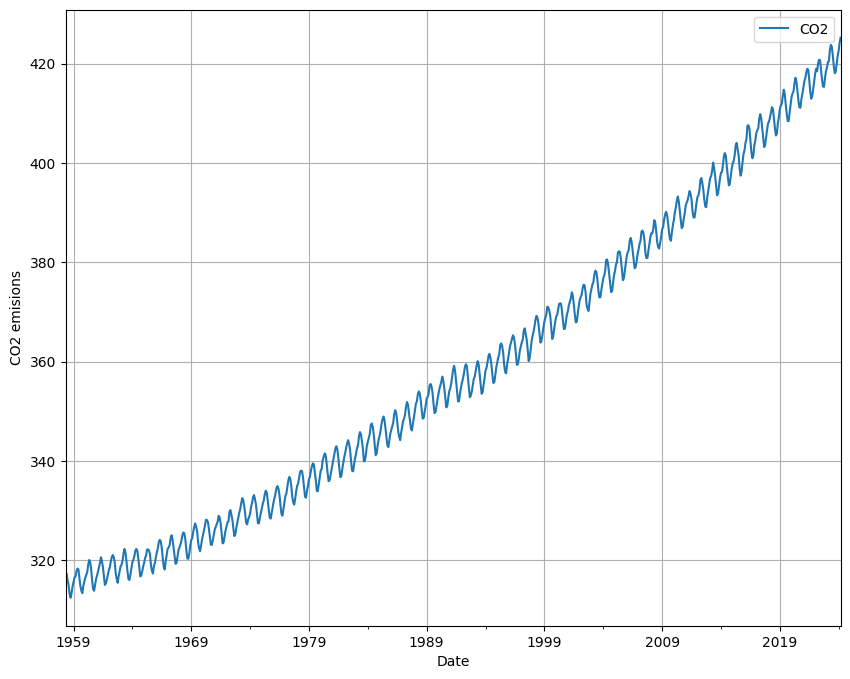

In [ ]:
co2_data.plot(figsize=(10,8), grid=True)
plt.ylabel("CO2 emisions")
plt.show()

In [ ]:
co2_data.sort_index(inplace=True)

In [ ]:
co2_data.index.freq='MS'
fcast_months = 24
train=co2_data.iloc[:-fcast_months ]
test=co2_data.iloc[-fcast_months :]
len(test)

24

using auto_arima for automatically selecting the optimal ARIMA model parameters for a given time series dataset

In [ ]:
auto_arima(train, seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  762
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.545
Date:                            Sun, 28 Apr 2024   AIC                            421.090
Time:                                    15:15:56   BIC                            444.263
Sample:                                10-01-1958   HQIC                           430.013
                                     - 03-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2673      0.075      3.566      0.000       0.120       0.414
ma.L1         -0.6162      0.060    -10.198      0.000      -0.735      -0.498
ar.S.L12       0.9996      0.000   2670.369      0.000       0.999       1.000
ma.S.L12      -0.8573      0.021    -41.643      0.000      -0.898      -0.817
sigma2         0.0935      0.004     21.690      0.000       0.085       0.102
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 4.75
Prob(Q):                              0.73   Prob(JB):                         0.09
Heteroskedasticity (H):               1.51   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using autoarima we see that are model to be used is a model with p =1 , difference = 1 and moving avg paramter q = 1

so we will move forward with traiing our data on this particular model

training on entire data except last 24 months and testing on last 24 months

In [ ]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12)).fit()
start=len(train)
end=start+len(test)-1
pred_arma=model.predict(start,end).rename('SARIMAX(1, 1, 1)x(1, 0, [1], 12)')

<Axes: xlabel='Date'>

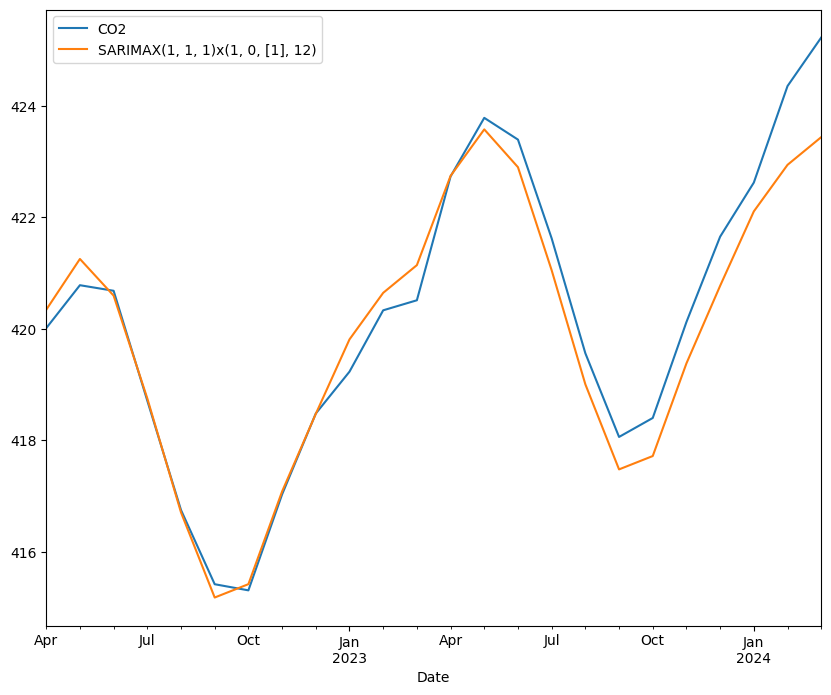

In [ ]:
ax=test.plot(figsize=(10,8),legend=True, label="Test")
pred_arma.plot(legend=True)

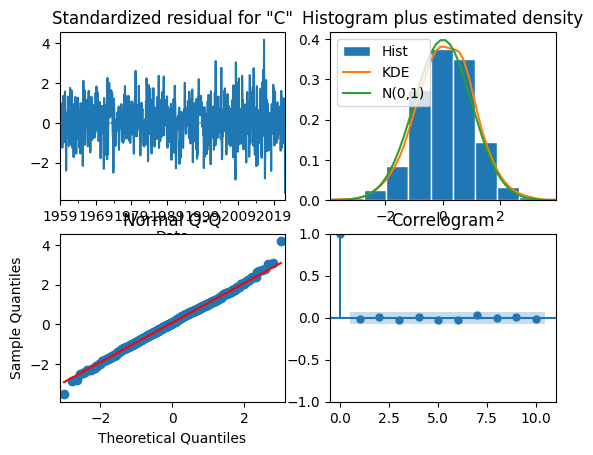

In [ ]:
model.plot_diagnostics();

In [ ]:
mape_sarima = mean_absolute_percentage_error(test, pred_arma)*100
print(f"Mean absolute percentage error : {mape_sarima}")

Mean absolute percentage error : 0.11208689399925485


We have no corelations in our residuals. plus our Histogram is close the the Normal districution plot N(0,1) and a good accuracy

In [ ]:
fits = {"Add-Add": ["add", "add"], "Add-Mul": ["add", "mul"], "Mul-Add": ["mul", "add"], "Mul-Mul": ["mul", "mul"]}
model_forecasts = {}
mape_scores =[]
for fit_type, value in fits.items() :
    fit = ExponentialSmoothing(
            train,
            seasonal_periods=12,
            trend= value[0],
            seasonal= value[1],
            initialization_method="estimated",
        ).fit()
    fcast = fit.forecast(len(test))
    mape = mean_absolute_percentage_error(test, fcast.values)*100
    mape_scores.append(mape)
    pred_hw = pd.Series(fcast.values)
    pred_hw.index = test.index
    model_forecasts[fit_type] = pred_hw

In [ ]:
for index, key in enumerate(fits.keys()):
    print(f"For {key}, Mean abs % error is {mape_scores[index]}")

For Add-Add, Mean abs % error is 0.11066239131961311
For Add-Mul, Mean abs % error is 0.1165543569966312
For Mul-Add, Mean abs % error is 0.10205117760524286
For Mul-Mul, Mean abs % error is 0.10883653500227147


<Axes: xlabel='Date'>

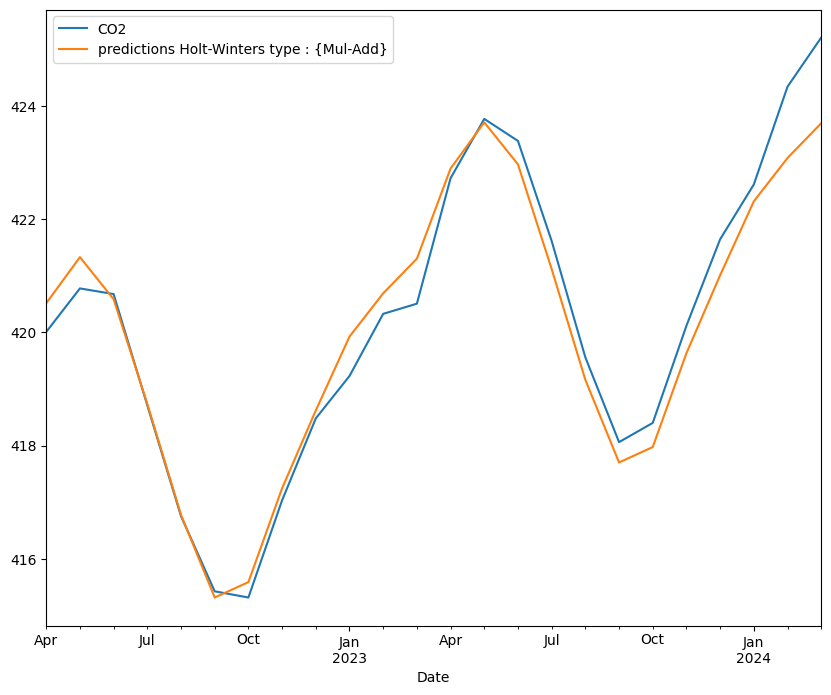

In [ ]:
ax=test.plot(figsize=(10,8),legend=True, label="Test")
model_forecasts["Mul-Add"].plot(legend=True, label="predictions Holt-Winters type : {Mul-Add}")

Means abs % error of our Sarima vs Holt Winters

In [ ]:
print(f"For SARIMA, Mean abs % error is {mape_sarima} \nFor HW lowest Means abs % err is for model with Multiplicative trend and additive seasonal component, with value {mape_scores[2]}")

For SARIMA, Mean abs % error is 0.11208689399925485 
For HW lowest Means abs % err is for model with Multiplicative trend and additive seasonal component, with value 0.10205117760524286


Predictions comparisions -> TEST vs HW vs SARIMA

<Axes: xlabel='Date'>

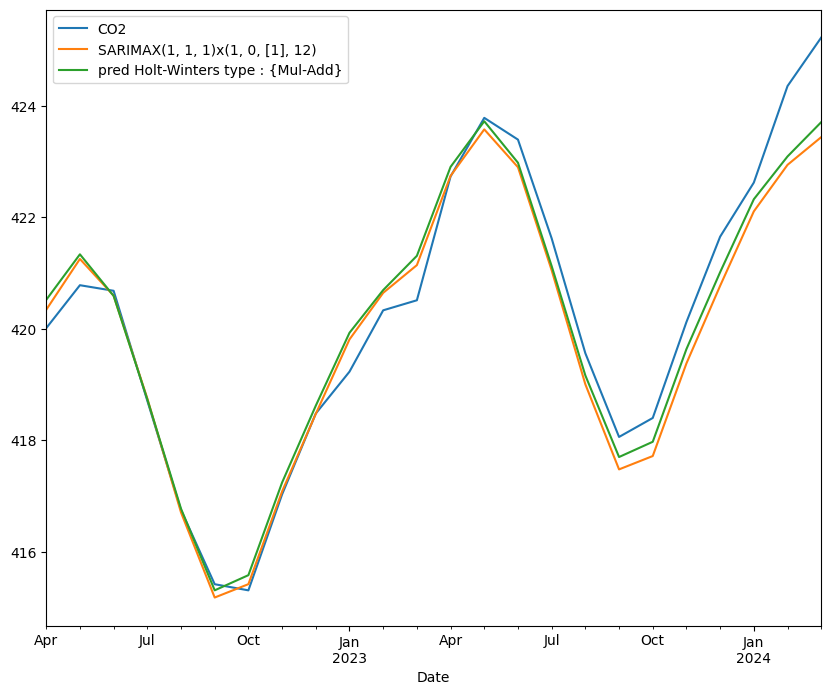

In [ ]:
ax=test.plot(figsize=(10,8), legend=True)
pred_arma.plot(legend=True)
model_forecasts["Mul-Add"].plot(legend=True,label="pred Holt-Winters type : {Mul-Add}")

In [ ]:
hw_acc = 100 -mape_scores[2]
sarima_acc = 100 - mape_sarima
print(f"Holt Winters = {hw_acc}, SARIMA : {sarima_acc}")

Holt Winters = 99.89794882239475, SARIMA : 99.88791310600074


The prediction accuracy for both models is > 99% with a very bare slight edge with holt winters (additive trend and multiplicative seasonal) components model